# CutMix 또는 Mixup 비교실험 하기

### 라이브러리 버전 확인하기

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


### 라이브러리 불러오기

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow_datasets as tfds

print('완료')

완료


### gpu 환결 확인하기

In [3]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
## 1. Augmentation을 적용한 데이터셋 만들기

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
print('완료')

완료


### 다운로드한 데이터셋 확인하기

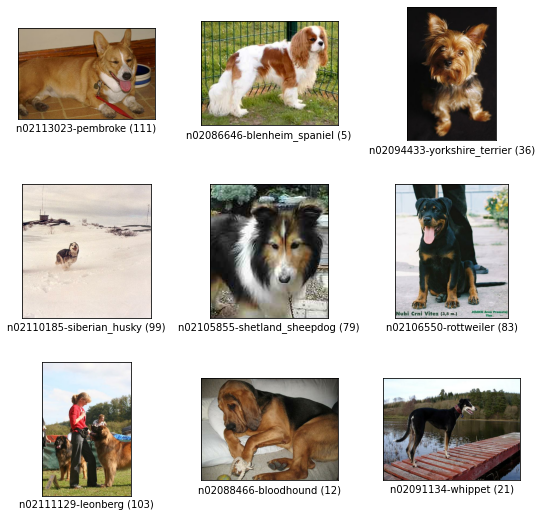

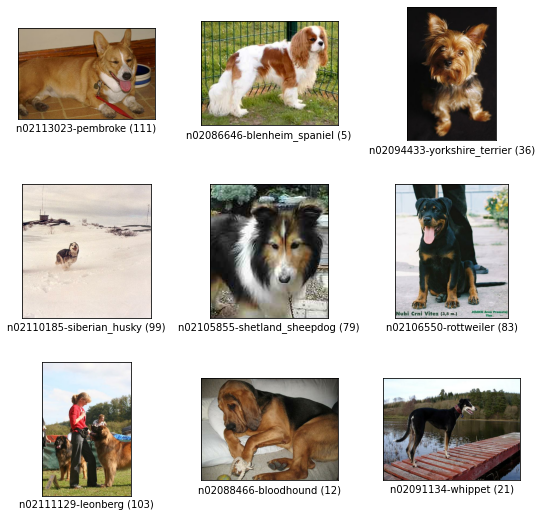

In [5]:
tfds.show_examples(ds_train, ds_info)

### Augmentation (기본)
- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()

In [6]:
# 전처리 함수
def normalize_and_resize_img(image, label): # 변환할 이미지와 라벨 
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.2) # 밝기 변화
    image = tf.clip_by_value(image, 0, 1)
    return image, label

## 라벨 원-핫 인코딩
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

### Cutmix Augmentation
- CutMix: Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법  

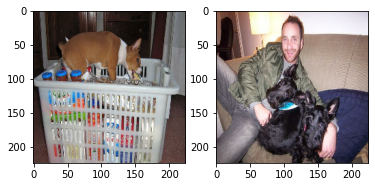

In [29]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_original.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [30]:
## 이미지 증강: cutmix
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(129, shape=(), dtype=int32)
y :  tf.Tensor(24, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


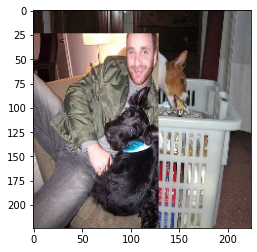

In [31]:
## mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [32]:
## mix two labels
# image_a: 섞이는 기준이 되는 이미지. 크기(shape)
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    
    # 이미지의 가로 크기와 세로 크기 가져오기
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # 섞이는 영역(mixed_area) 크기 계산
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    
    # 섞이는 영역의 비율 계산 (혼합 영역의 면적 비율)
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    # 라벨이 스칼라 값(숫자)일 경우 원-핫 인코딩 수행
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    # 두 라벨을 비율에 따라 혼합
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.5141901 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [33]:
## Cutmix 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('완료')

완료


### Mixup Augmentation
- 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑는다.
- 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어준다.

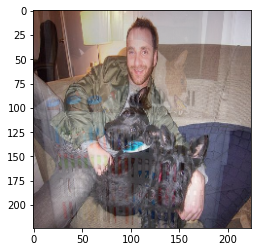

In [34]:
## 이미지 증강: mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img2, mixed_label2 = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img2.numpy())
plt.show()

In [35]:
print(mixed_label2)

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.73317575 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [12]:
## Mixup
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 데이터 전처리 및 augmentation 제작하기

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    ## test 데이터가 아니면서 aug를 할 데이터 셋
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    ## test 데이터가 아니면서 cutmix 할 데이터 셋
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    ## test 데이터가 아니면서 mixup 할 데이터 셋
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('완료')

완료


In [14]:
num_classes = ds_info.features["label"].num_classes

In [15]:
## 증강 없음
ds_train_original = apply_normalize_on_dataset(ds_train, is_test=False, with_aug=False, with_cutmix=False)
# 기본 증강
ds_train_aug = apply_normalize_on_dataset(ds_train,is_test=False, with_aug=True, with_cutmix=False, with_mixup=False)
# cutmix 증강
ds_train_cutmix = apply_normalize_on_dataset(ds_train,is_test=False, with_aug=False, with_cutmix=True, with_mixup=False)
# mixup 증강
ds_train_mixup = apply_normalize_on_dataset(ds_train,is_test=False, with_aug=False, with_cutmix=False, with_mixup=True)
# 증강 테스트
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, with_aug=False, with_cutmix=False)

---
## 2. 모델 만들기
- 앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요
- 모델은 ResNet-50을 사용합시다

In [16]:
# resnet50 증강 없음
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# resnet50 기본 증강
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# cutmix 증강
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# mixup 증강
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

print('완료')

완료


---

## 3. 모델 훈련하기
- 주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

In [17]:
EPOCH = 20

### resnet50 증강 없음

In [18]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_original, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


750/750 [==============================] - 184s 200ms/step - loss: 2.2052 - accuracy: 0.4486 - val_loss: 2.8702 - val_accuracy: 0.2853
Epoch 2/20
750/750 [==============================] - 152s 202ms/step - loss: 0.7874 - accuracy: 0.7777 - val_loss: 1.2647 - val_accuracy: 0.6343
Epoch 3/20
750/750 [==============================] - 152s 202ms/step - loss: 0.2771 - accuracy: 0.9362 - val_loss: 0.9835 - val_accuracy: 0.7144
Epoch 4/20
750/750 [==============================] - 152s 202ms/step - loss: 0.0856 - accuracy: 0.9893 - val_loss: 0.9369 - val_accuracy: 0.7299
Epoch 5/20
750/750 [==============================] - 152s 202ms/step - loss: 0.0296 - accuracy: 0.9983 - val_loss: 0.9288 - val_accuracy: 0.7399
Epoch 6/20
750/750 [==============================] - 152s 202ms/step - loss: 0.0165 - accuracy: 0.9997 - val_loss: 0.9317 - val_accuracy: 0.7435
Epoch 7/20
750/750 [==============================] - 151s 202ms/step - loss: 0.0116 - accuracy: 0.9999 - val_loss: 0.9449 - val_accura

### resnet50 기본 증강

In [19]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_original, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 158s 203ms/step - loss: 2.2008 - accuracy: 0.4495 - val_loss: 3.4051 - val_accuracy: 0.1979
Epoch 2/20
750/750 [==============================] - 151s 202ms/step - loss: 0.6987 - accuracy: 0.8080 - val_loss: 1.0836 - val_accuracy: 0.6853
Epoch 3/20
750/750 [==============================] - 151s 202ms/step - loss: 0.2105 - accuracy: 0.9578 - val_loss: 0.9623 - val_accuracy: 0.7232
Epoch 4/20
750/750 [==============================] - 151s 202ms/step - loss: 0.0615 - accuracy: 0.9951 - val_loss: 0.9134 - val_accuracy: 0.7366
Epoch 5/20
750/750 [==============================] - 167s 223ms/step - loss: 0.0284 - accuracy: 0.9990 - val_loss: 0.9170 - val_accuracy: 0.7416
Epoch 6/20
750/750 [==============================] - 152s 202ms/step - loss: 0.0152 - accuracy: 0.9998 - val_loss: 0.9253 - val_accuracy: 0.7441
Epoch 7/20
750/750 [==============================] - 151s 202ms/step - loss: 0.0124 - accuracy: 0.9998 - val_loss: 0.9496 -

### cutmix 증강

In [20]:
cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_aug_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 205ms/step - loss: 3.8415 - accuracy: 0.2126 - val_loss: 3.3259 - val_accuracy: 0.2149
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 2.9328 - accuracy: 0.4348 - val_loss: 1.2880 - val_accuracy: 0.6343
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 2.6336 - accuracy: 0.5404 - val_loss: 1.3320 - val_accuracy: 0.6280
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.4099 - accuracy: 0.6040 - val_loss: 1.2128 - val_accuracy: 0.6666
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 2.2449 - accuracy: 0.6650 - val_loss: 1.2490 - val_accuracy: 0.6651
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 2.1357 - accuracy: 0.6925 - val_loss: 1.3343 - val_accuracy: 0.6399
Epoch 7/20
750/750 [==============================] - 153s 205ms/step - loss: 2.0401 - accuracy: 0.7257 - val_loss: 1.3035 -

### mixup 증강

In [21]:
mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_aug_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 161s 205ms/step - loss: 3.7432 - accuracy: 0.2400 - val_loss: 3.9738 - val_accuracy: 0.1332
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 2.8709 - accuracy: 0.4750 - val_loss: 1.4893 - val_accuracy: 0.5827
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 2.5786 - accuracy: 0.5816 - val_loss: 1.4820 - val_accuracy: 0.5880
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.3903 - accuracy: 0.6600 - val_loss: 1.3463 - val_accuracy: 0.6294
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 2.2469 - accuracy: 0.7097 - val_loss: 1.2351 - val_accuracy: 0.6538
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 2.1378 - accuracy: 0.7504 - val_loss: 1.3462 - val_accuracy: 0.6377
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 2.0687 - accuracy: 0.7753 - val_loss: 1.1845 -

---

## 4. 훈련 과정 시각화하기
- 훈련 과정의 히스토리를 그래프로 시각화해 주세요

### Accuracy (val)

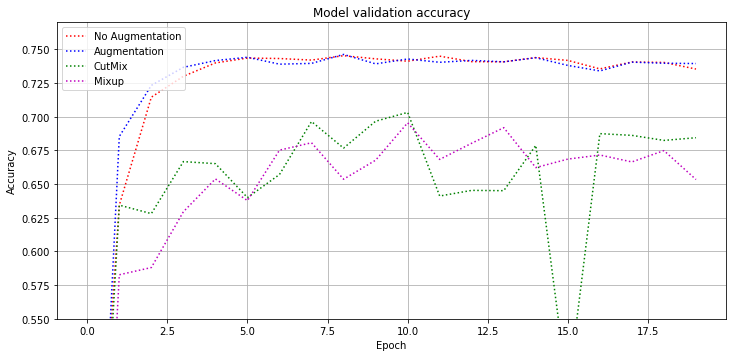

In [40]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r:')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b:')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g:')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm:')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.55, 0.770)   

plt.show()

- 증폭 없음과 기본 증폭은 그래프가 안정적이지만 cutmix와 mixup은 20에폭까지 크게 진동하는 모습을 보인다
- 에폭을 극단적으로 늘려 학습하면 어떤 형태를 보일지 궁금하다
- 모든 모델이 acc가 0.75를 넘기지 못했다 전체적인 정확도도 증가할 수 있는 방법을 찾아봐야 할 것 같다

### Loss (val)

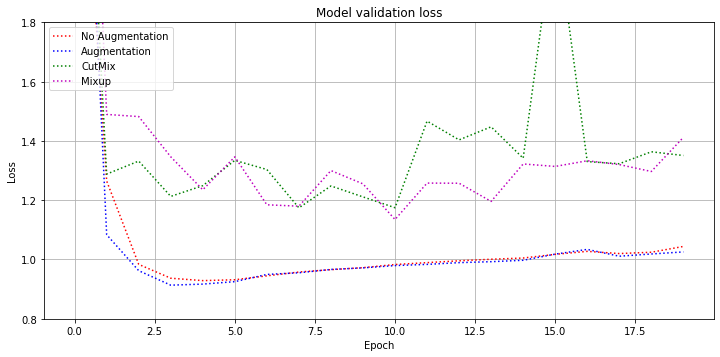

In [41]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r:')
plt.plot(history_resnet50_aug.history['val_loss'], 'b:')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g:')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm:')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.80, 1.80)  
plt.show()

plt.show()

- acc와 마찬가지로 증폭 없음과 기본 증폭은 안정적이지만 cutmix와 mixup은 크게 진동한다
- 증폭 없음과 기본 증폭은 3 에폭에서 5에폭 사이에 오버피팅이 발생한 것 같다
- cutmix와 mixup도 그래프가 증가하는 모습을 보이지만 아직 오버피팅은 발생하지 않은 것 같기 때문에 추가적으로 학습을 진행해봐야 할 것 같다

---

## 5. Augmentation에 의한 모델 성능 비교
- No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요

### Accuracy (val)

In [24]:
val_acc_dict = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'], 
            'Augmentation': history_resnet50_aug.history['val_accuracy'], 
            'CutMix': history_resnet50_cutmix.history['val_accuracy'], 
            'Mixup': history_resnet50_mixup.history['val_accuracy']}
df1 = pd.DataFrame(val_acc_dict)
df1

,No Augmentation,Augmentation,CutMix,Mixup
0,0.285331,0.197878,0.214902,0.133162
1,0.634328,0.685284,0.634328,0.582673
2,0.714436,0.723181,0.628032,0.588036
3,0.729944,0.736591,0.666628,0.629431
4,0.739855,0.741605,0.665112,0.653801
5,0.743470,0.744053,0.639925,0.637710
6,0.743120,0.738923,0.657066,0.675140
7,0.741954,0.739506,0.696362,0.680620
8,0.745219,0.746152,0.676656,0.653568
9,0.742887,0.739156,0.696595,0.667677


In [25]:
acc_mean = df1.mean()
acc_mean

No Augmentation    0.711252
Augmentation       0.709643
CutMix             0.636235
Mixup              0.631716
dtype: float64

### Loss (val)

In [26]:
val_loss_dict = {'No Augmentation': history_resnet50_no_aug.history['val_loss'], 
            'Augmentation': history_resnet50_aug.history['val_loss'], 
            'CutMix': history_resnet50_cutmix.history['val_loss'], 
            'Mixup': history_resnet50_mixup.history['val_loss']}
df2 = pd.DataFrame(val_loss_dict)
df2

,No Augmentation,Augmentation,CutMix,Mixup
0,2.870232,3.405141,3.325929,3.973833
1,1.264735,1.083588,1.287992,1.489268
2,0.983540,0.962289,1.331970,1.482036
3,0.936864,0.913430,1.212839,1.346333
4,0.928757,0.917032,1.248962,1.235132
5,0.931669,0.925301,1.334345,1.346155
6,0.944882,0.949601,1.303478,1.184498
7,0.957727,0.955229,1.174196,1.179791
8,0.965731,0.966486,1.248045,1.299908
9,0.972409,0.971707,1.211146,1.255040


In [27]:
loss_mean = df2.mean()
loss_mean

No Augmentation    1.093193
Augmentation       1.104985
CutMix             1.450843
Mixup              1.431780
dtype: float64

---
## 회고
- 한 에폭마다 2분에서 3분 정도의 시간이 걸려 전체 학습 시간이 아주 오래걸렸다
- cutmix와 mixup의 그래프가 진동하는 것을 보아 에폭 수를 더 늘려서 추가적으로 학습을 진행해보고 싶다  


- 퍼실님께서 그래프에 대한 분석을 추천해주셔서 오늘 처음 진행해보았는데 정확한 결과를 얻으려면 에폭을 늘리며 acc와 loss값을 변화를 계속해서 확인하는 것이 필요할 것 같다는 생각을 했다